<a href="https://colab.research.google.com/github/tinayiluo0322/Computer-Engineering-Machine-Learning-and-Deep-Neural-Nets-Projects/blob/main/SimpleNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For getting started with deep Neural Network model easily, we consider a simple Neural Network model here and details of the model architecture is given in Table 1. This lab question focuses on building the model in PyTorch and observing the shape of each layer’s input, weight and output.

In [8]:
import argparse
import os, sys
import time
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.utils import _single, _pair, _triple
import random

In [9]:
seed = 42
random.seed(seed)  # Python's random module
np.random.seed(seed)  # NumPy's random module
torch.manual_seed(seed)  # PyTorch's random seed for CPU
torch.cuda.manual_seed(seed)  # PyTorch's random seed for the current GPU
torch.cuda.manual_seed_all(seed)  # PyTorch's random seed for all GPUs (if using multi-GPU)

# Ensure deterministic behavior on GPU (optional, may slow down training)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optional: Set environment variables for further reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)

Customized implementation of [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)

In [10]:
class CONV(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=False, padding_mode='zeros'):
        self.input = None
        self.output = None
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(CONV, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            groups, bias, padding_mode)

    def forward(self, input):
        self.input = input
        # 'pytorch 2.0'
        self.output = super().forward(input)
        return self.output

class FC(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        self.input = None
        self.output = None
        super(FC, self).__init__(in_features, out_features, bias)

    def forward(self, input):
        self.input = input
        self.output = F.linear(input, self.weight, self.bias)
        return self.output

In [11]:
# Create the neural network module: SimpleNN
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Layer definition
        self.conv1 = CONV(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = CONV(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=2)
        self.conv3 = CONV(in_channels=16, out_channels=32, kernel_size=7, stride=1, padding=2)
        self.fc1 = FC(in_features=32 * 3 * 3, out_features=32)  # Flatten size for FC1: (32 filters, 2x2 feature map)
        self.fc2 = FC(in_features=32, out_features=10)  # Output size is 10

        self.pool = nn.MaxPool2d(kernel_size=4, stride=2)  # MaxPool1
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)  # MaxPool2
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPool3

    def forward(self, x):
        # Conv 1
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        # Conv 2
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Conv 3
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten
        x = torch.flatten(x, start_dim=1)

        # FC 1
        x = F.relu(self.fc1(x))

        # FC 2
        out = F.relu(self.fc2(x))

        return out

# GPU check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition
net = SimpleNN()
net = net.to(device)

# Test forward pass
data = torch.randn(5, 3, 32, 32)  # Batch size = 5, Input channels = 3, Image size = 32x32
data = data.to(device)

# Forward pass "data" through "net" to get output "out"
out = net(data)

# Check output shape
assert(out.detach().cpu().numpy().shape == (5, 10))  # Output shape should match batch size x 10 classes
print("Forward pass successful")

Run on CPU...
Forward pass successful


In [12]:
"""
Lab 2(b)
"""
# Forward pass of a single image
data = torch.randn(1, 3, 32, 32).to(device)  # Batch size = 1, Input channels = 3, Image size = 32x32
# Forward pass "data" through "net" to get output "out"
out = net(data)

# Iterate through all the CONV and FC layers of the model
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the input feature map of the module
        input = module.input.detach().cpu().numpy()  # Use the customized CONV and FC classes
        # Get the output feature map of the module
        output = module.output.detach().cpu().numpy()
        # Get the weight of the module
        weight = module.weight.detach().cpu().numpy()
        # Compute the number of parameters in the weight
        num_Param = weight.size  # Total elements in the weight tensor
        # Compute the number of MACs in the layer
        if isinstance(module, CONV):
            # MACs = (Output Channels) * (Input Channels) * (Kernel Height) * (Kernel Width) * (Output Height) * (Output Width)
            out_channels, in_channels, kernel_h, kernel_w = weight.shape
            _, _, out_h, out_w = output.shape
            num_MAC = out_channels * in_channels * kernel_h * kernel_w * out_h * out_w
        elif isinstance(module, FC):
            # MACs = (Input Features) * (Output Features)
            in_features, out_features = weight.shape
            num_MAC = in_features * out_features

        # Print layer details
        print(f'{name:10} {str(input.shape):20} {str(output.shape):20} {str(weight.shape):20} {str(num_Param):10} {str(num_MAC):10}')

conv1      (1, 3, 32, 32)       (1, 16, 32, 32)      (16, 3, 5, 5)        1200       1228800   
conv2      (1, 16, 15, 15)      (1, 16, 17, 17)      (16, 16, 3, 3)       2304       665856    
conv3      (1, 16, 8, 8)        (1, 32, 6, 6)        (32, 16, 7, 7)       25088      903168    
fc1        (1, 288)             (1, 32)              (32, 288)            9216       9216      
fc2        (1, 32)              (1, 10)              (10, 32)             320        320       


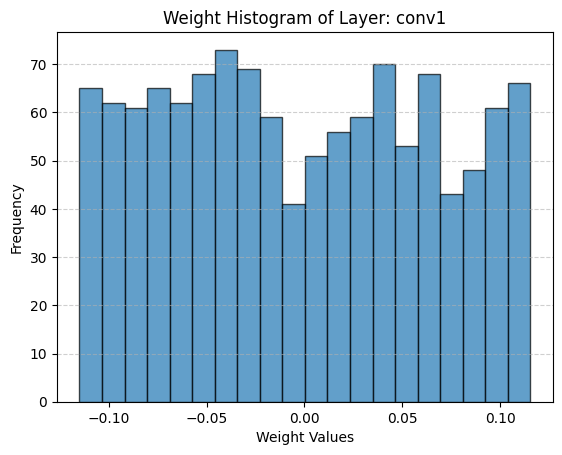

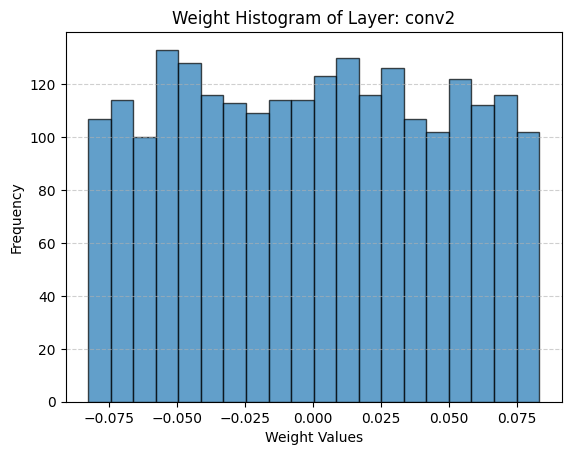

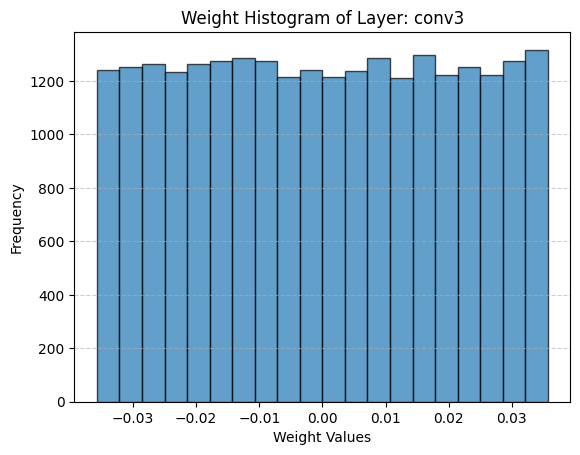

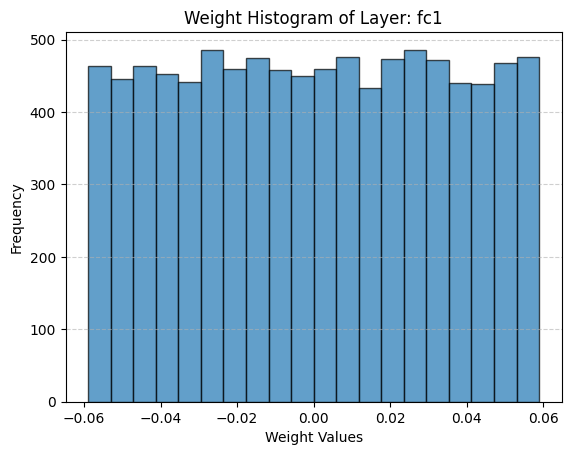

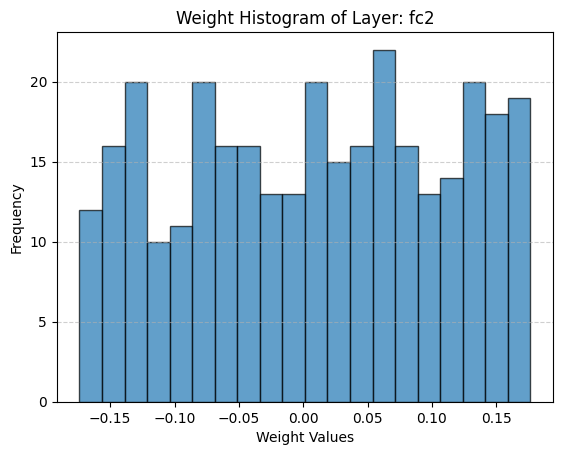

In [13]:
"""
Lab 3(a)
"""
# Iterate through all the CONV and FC layers of the model
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the weight of the module as a NumPy array
        weight = module.weight.detach().cpu().numpy()  # Access the weights from the module

        # Reshape for histogram
        weight = weight.reshape(-1)  # Flatten the weights into a 1D array
        _ = plt.hist(weight, bins=20, edgecolor='black', alpha=0.7)  # Plot histogram
        plt.title(f"Weight Histogram of Layer: {name}")
        plt.xlabel("Weight Values")
        plt.ylabel("Frequency")
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()  # Display the histogram

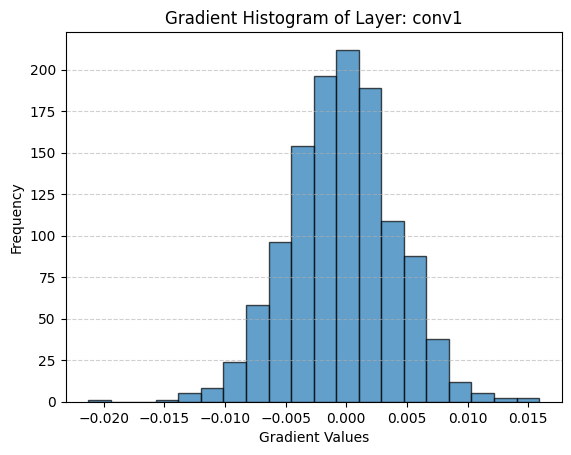

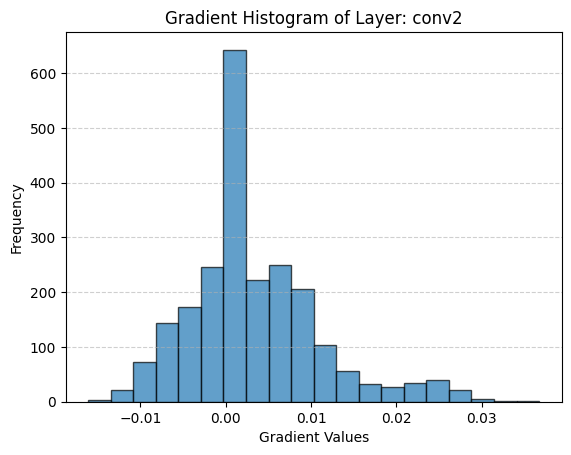

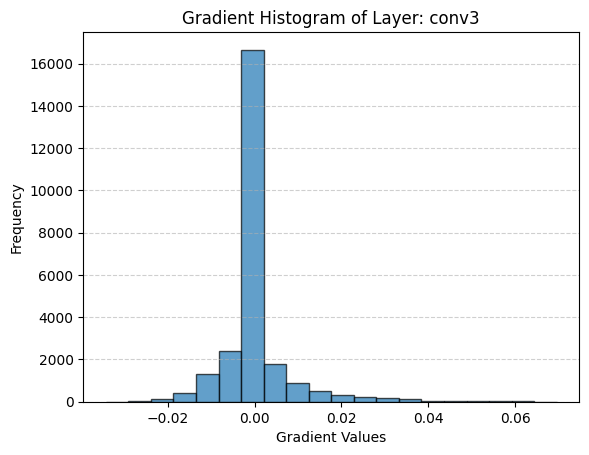

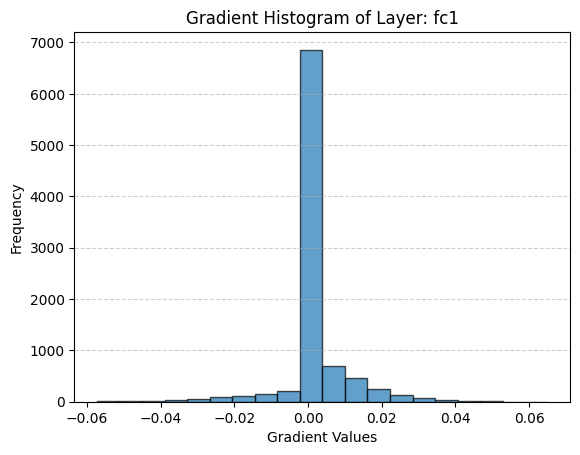

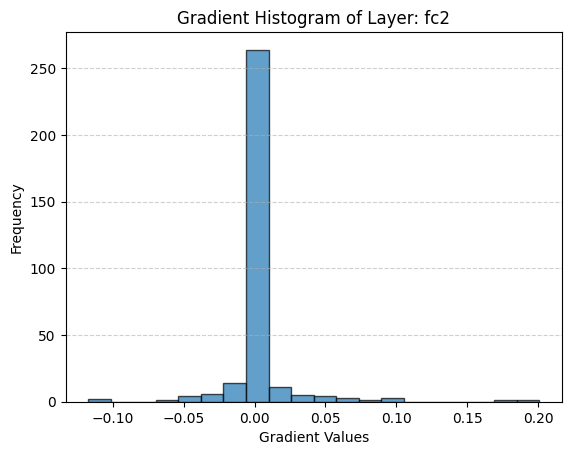

In [14]:
'''
Lab 3(b)
'''
# Loss definition
criterion = nn.MSELoss()

# Random target
target = torch.randn(1, 10).to(device)  # Randomly generated target with the same shape as output

# Loss computation
loss = criterion(out, target)  # Compute the loss between output and target

# Backward pass for gradients
loss.backward()  # Compute gradients for all parameters

# Iterate through all the CONV and FC layers of the model
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module's weights as a NumPy array
        gradient = module.weight.grad.detach().cpu().numpy()  # Access gradients

        # Reshape for histogram
        gradient = gradient.reshape(-1)  # Flatten the gradients into a 1D array
        _ = plt.hist(gradient, bins=20, edgecolor='black', alpha=0.7)  # Plot histogram
        plt.title(f"Gradient Histogram of Layer: {name}")
        plt.xlabel("Gradient Values")
        plt.ylabel("Frequency")
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()  # Display the histogram

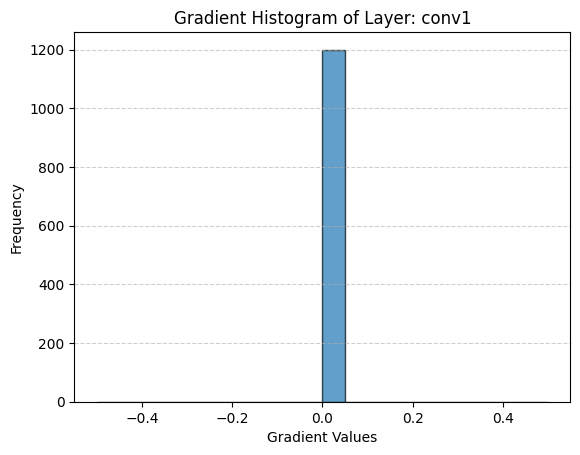

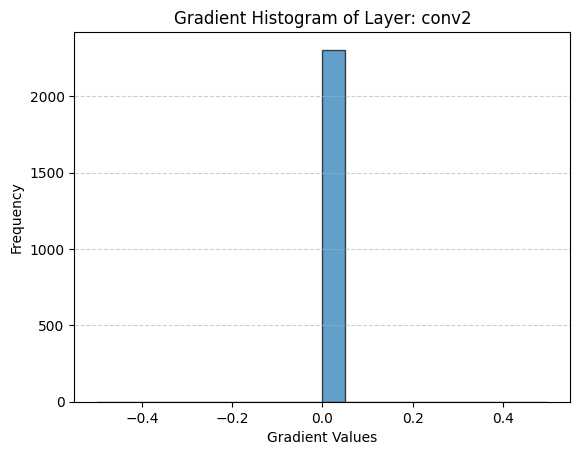

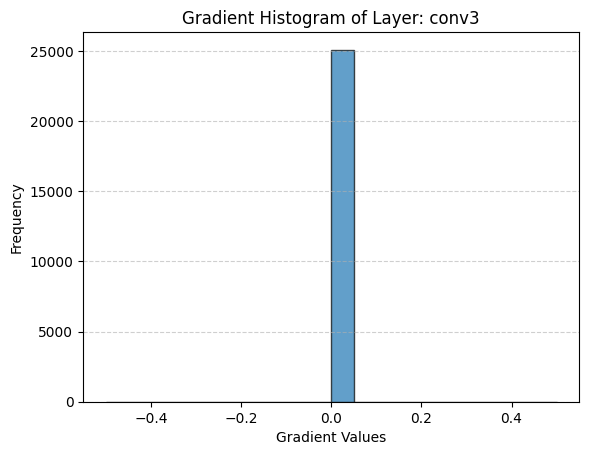

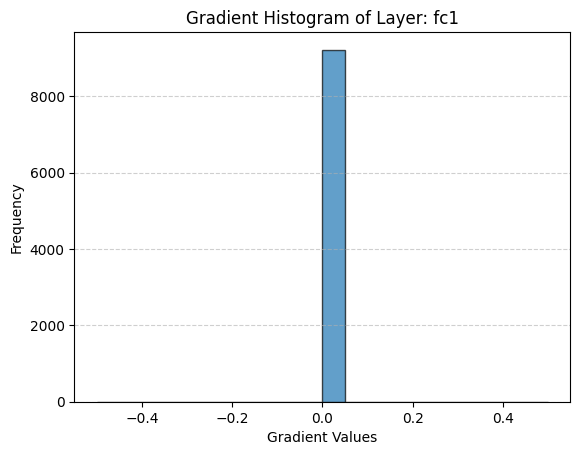

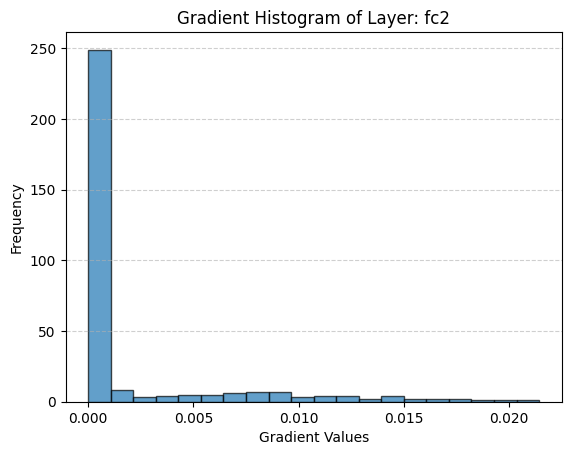

In [15]:
'''
Lab 3(c)
'''
# Set model weights to zero
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Set the weight of each module to all zeros
        module.weight.data.fill_(0)  # Fill the weight tensor with zeros

# Reset gradients
net.zero_grad()

# Forward and backward pass
# Random data and target
data = torch.randn(1, 3, 32, 32).to(device)  # Random input image
target = torch.randn(1, 10).to(device)  # Random target output

# Forward pass
out = net(data)  # Compute the forward pass through the model

# Loss computation
criterion = nn.MSELoss()
loss = criterion(out, target)  # Compute the loss between output and target

# Backward pass
loss.backward()  # Compute gradients for all parameters

# Plot histograms of gradients
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module's weights as a NumPy array
        gradient = module.weight.grad.detach().cpu().numpy()

        # Reshape for histogram
        gradient = gradient.reshape(-1)  # Flatten the gradients into a 1D array
        _ = plt.hist(gradient, bins=20, edgecolor='black', alpha=0.7)  # Plot histogram
        plt.title(f"Gradient Histogram of Layer: {name}")
        plt.xlabel("Gradient Values")
        plt.ylabel("Frequency")
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()

Comparison with Previous Gradients

With Random Initialization (from Lab 3(b)): Gradients will have a diverse distribution because the weights are initialized with random values.
This diversity enables effective learning during optimization.

With Zero Initialization:Gradients for all neurons in the same layer will be identical, resulting in highly concentrated histograms (a single peak or narrow range). This occurs because, with zero-initialized weights, all neurons in the same layer receive the same gradient during backpropagation.

Analysis of the Difference

Cause of the Difference: When all weights are initialized to zero, the symmetry in the network causes all neurons in a layer to learn identical weights.This prevents the network from effectively breaking symmetry and learning diverse features, making training ineffective.

Impact on Training: Initializing weights to zero will prevent the CNN from learning because all neurons in the same layer will compute the same output and gradient. This is why weight initialization methods (e.g., random initialization) are crucial for effective training.